# 1. Importing data and libraries <a class="anchor" id="1"></a>

In [27]:
# Import packages
import pandas as pd
import numpy as np
import datetime as dt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import plotly.express as px
from os import path
from wordcloud import WordCloud

In [2]:
# Import dataset
df_orderproduct = pd.read_csv('datasets/order_products.csv')
df_products = pd.read_csv('datasets/products.csv')
df_orders = pd.read_csv('datasets/orders.csv')
df_department = pd.read_csv('datasets/departments.csv')

# 2. Exploratory Data Analysis <a class="anchor" id="2"></a>

## Orders information

In [3]:
df_orders.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2425083,49125,1,2,18,NaN
1,1944304,162867,1,3,17,NaN
2,1201011,147243,14,0,16,3.0
3,1906860,195275,81,1,11,3.0
4,2766469,58222,3,6,11,6.0


### Frequency of Reorders in a Week

Explore the change of order numbers from Monday to Sunday.

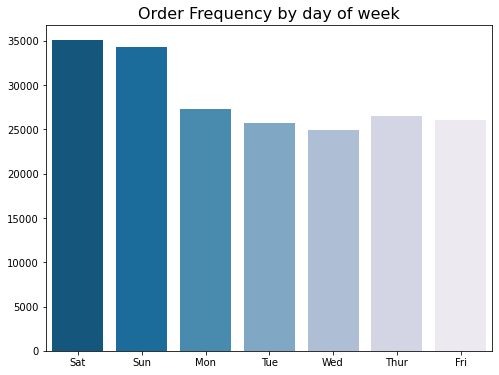

In [4]:
plot_df = df_orders['order_dow'].value_counts().sort_index()
plot_df.index=['Sat', 'Sun', 'Mon', 'Tue', 'Wed', 'Thur', 'Fri']
# show figure:
plt.figure(figsize=(8, 6))
sns.barplot(y = plot_df.values, x = plot_df.index, palette="PuBu_r")
plt.xticks(rotation=0)
plt.title('Order Frequency by day of week', fontsize=16)
plt.show()

### Frequency of Reorders in Hour of Day

Explore how order number changes in the hour of day.

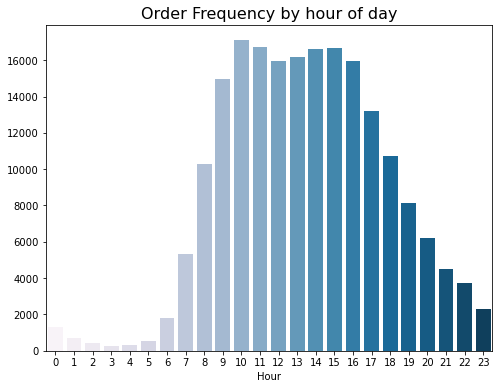

In [5]:
plot_df = df_orders['order_hour_of_day'].value_counts().sort_index()
# show figure:
plt.figure(figsize=(8, 6))
sns.barplot(y = plot_df.values, x = plot_df.index, palette="PuBu")
plt.xticks(rotation=0)
plt.title('Order Frequency by hour of day', fontsize=16)
plt.xlabel('Hour')
plt.show()
#fig.set_dpi(200)

### Frequency of Reorder Interval

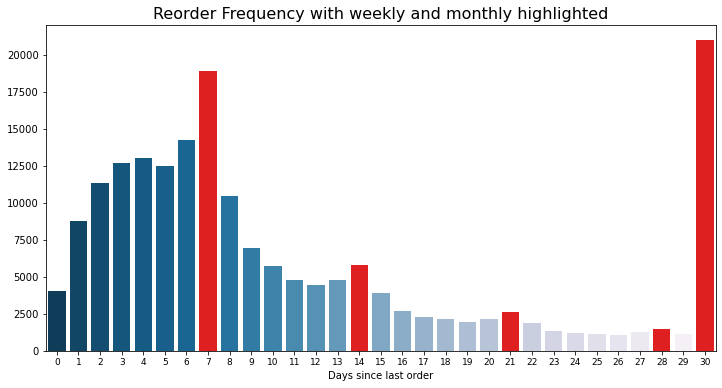

In [6]:
plot_df = df_orders.groupby('days_since_prior_order')['order_id'].agg('count')
color_pl = sns.color_palette(palette="PuBu_r", n_colors=len(plot_df.index))
highlight  = [7,14,21,28,30] 
for i in highlight:
    color_pl[i] = 'red'
# show figure:
plt.figure(figsize=(12, 6))
sns.barplot(y = plot_df.values, x = list(range(len(plot_df.index))), palette=color_pl)
plt.xticks(rotation=0)
plt.title('Reorder Frequency with weekly and monthly highlighted', fontsize=16)
plt.xticks(range(len(plot_df.index)), rotation=0,fontsize=9)
plt.xlabel('Days since last order')
plt.show()
#fig.set_dpi(200)

###  Average Reorder Interval

How often do customers put a new order?

<Figure size 864x432 with 0 Axes>

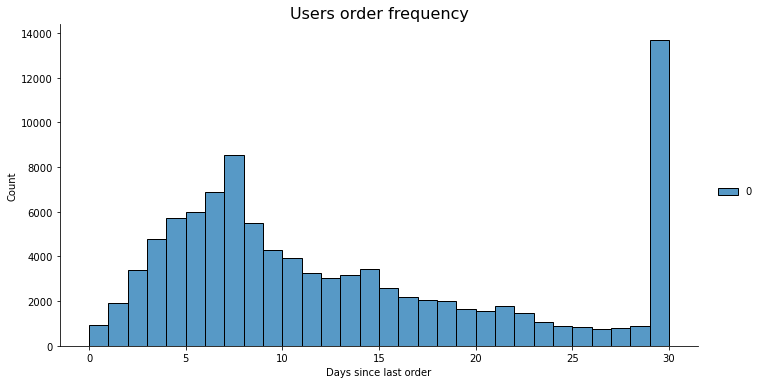

In [7]:
plot_df = df_orders[['user_id','days_since_prior_order']].groupby('user_id').aggregate(np.nanmean)
# show figure:
plt.figure(figsize=(12, 6))
sns.displot(plot_df.values, binwidth=1,aspect=2)
plt.xticks(rotation=0)
plt.title('Users order frequency', fontsize=16)
plt.xlabel('Days since last order')
plt.show()

## Popular Items in Shopping Cart History

In this part, let's see what are the most popular items on customers' order lists.

First take a look at each dataset, and then merge them into one dataframe with all the following included:
* user_id
* order_id
* product_id
* product_name

In [8]:
# orders in prior/train merged with product names
df = pd.merge(df_orderproduct,df_products, how='left', on='product_id')
# Prior orders with user_id, product_id, product_name
df = pd.merge(df,df_orders, how='left', on='order_id')

In [9]:
df.head()

,order_id,product_id,add_to_cart_order,reordered,department_id,product_name,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,10,24,1,1,4,fresh fruits,135442,4,6,8,8.0
1,10,83,2,1,4,fresh vegetables,135442,4,6,8,8.0
2,10,16,3,0,4,fresh herbs,135442,4,6,8,8.0
3,10,24,4,1,4,fresh fruits,135442,4,6,8,8.0
4,10,83,5,1,4,fresh vegetables,135442,4,6,8,8.0


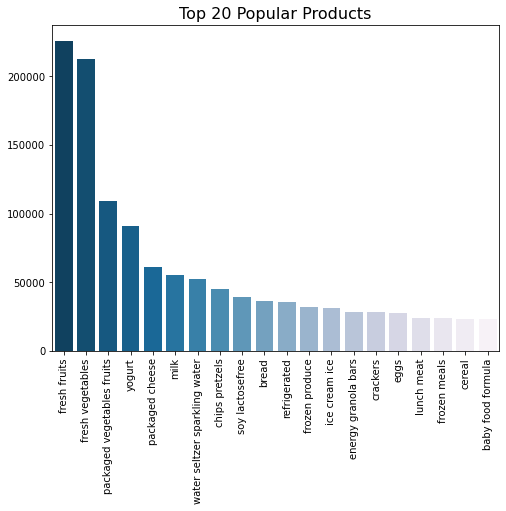

In [10]:
plot_df = df['product_name'].value_counts()[:20]
# show figure:
plt.figure(figsize=(8, 6))
sns.barplot(y = plot_df.values, x = plot_df.index, palette="PuBu_r")
plt.xticks(rotation=90)
plt.title('Top 20 Popular Products', fontsize=16)
plt.show()
#fig.set_dpi(200)

In [11]:
products_tuple_list = [tuple(x) for x in df['product_name'].value_counts().reset_index().values]
dic = {}
for pair in products_tuple_list:
    key = pair[0]
    value = pair[1]
    if key in dic:
        reservedValue = dic[key]
        reservedValue += value 
    else:
        dic[key] = value

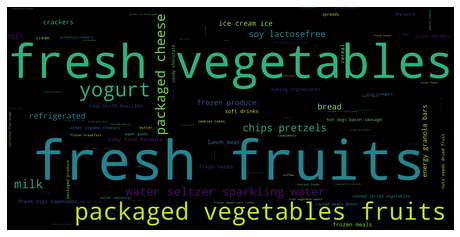

In [12]:
fig = plt.figure(figsize=(8, 6))
wordcloudData = WordCloud(width=4096,height=2048,
                          relative_scaling=1,
                          max_words = 100,
                          max_font_size=500).generate_from_frequencies(frequencies = dic)
plt.imshow(wordcloudData, interpolation='lanczos')
plt.axis("off")
plt.show()

# 3. Recommendatio system

In [63]:
df_orderproduct.head()

,order_id,product_id,add_to_cart_order,reordered
0,10,24,1,1
1,10,83,2,1
2,10,16,3,0
3,10,24,4,1
4,10,83,5,1


In [64]:
# Import product label mapping
df_products.head()

,product_id,department_id,product_name
0,61,19,cookies cakes
1,104,13,spices seasonings
2,94,7,tea
3,38,1,frozen meals
4,5,13,marinades meat preparation


In [65]:
# Merge product labels
df = pd.merge(df_orderproduct, df_products, how='left', on='product_id').\
    drop(["product_id", "department_id","add_to_cart_order","reordered"], axis=1)
df.head()

,order_id,product_name
0,10,fresh fruits
1,10,fresh vegetables
2,10,fresh herbs
3,10,fresh fruits
4,10,fresh vegetables


In [68]:
df_prod_dept = pd.merge(df_products,df_department, left_on="department_id", right_on="department_id")\
            .drop(columns=['product_id','department_id'])

In [69]:
# Pivot the data - lines as orders and products as columns
pt = pd.pivot_table(df, index='order_id', columns='product_name', 
                    aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)
pt.head()

product_name,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
order_id,,,,,,,,,,,,,,,,,,,,,
10,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
# Apply the APRIORI algorithm to get frequent itemsets
# Rules supported in at least 5% of the transactions (more info at http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/)
frequent_itemsets = apriori(pt, min_support=0.05, use_colnames=True)
frequent_itemsets.head()

,support,itemsets
0,0.076635,(baking ingredients)
1,0.163865,(bread)
2,0.067765,(breakfast bakery)
3,0.074330,(butter)
4,0.069305,(candy chocolate)


## Complementary & Substitutions

In [71]:
# Generate the association rules - by confidence
rulesConfidence = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.20)
rulesConfidence.sort_values(by='confidence', ascending=False, inplace=True)
rulesConfidence.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
133,"(fresh herbs, fresh fruits)",(fresh vegetables),0.070135,0.444360,0.061815,0.881372,1.983463,0.030650,4.683872
269,"(packaged vegetables fruits, yogurt, fresh veg...",(fresh fruits),0.087995,0.555995,0.076240,0.866413,1.558311,0.027315,3.323711
248,"(packaged vegetables fruits, milk, fresh veget...",(fresh fruits),0.073075,0.555995,0.062535,0.855765,1.539159,0.021906,3.078336
58,(fresh herbs),(fresh vegetables),0.093005,0.444360,0.078655,0.845707,1.903203,0.037327,3.601205
258,"(packaged vegetables fruits, packaged cheese, ...",(fresh fruits),0.081970,0.555995,0.068325,0.833537,1.499180,0.022750,2.667284


In [72]:
treemap_df = df.groupby('product_name').count().reset_index()
treemap_df = pd.merge(treemap_df,df_prod_dept, left_on="product_name", right_on="product_name").rename(columns ={"order_id":"quantity"})

fig = px.treemap(treemap_df, path=['department', 'product_name'],values="quantity",width=1000,height=700)
fig.show()

In [73]:
treemap_df.groupby("department").count()

,product_name,quantity
department,,
alcohol,5,5
babies,4,4
bakery,5,5
beverages,8,8
breakfast,4,4
bulk,2,2
canned goods,5,5
dairy eggs,10,10
deli,5,5


In [74]:
dict_product = df_prod_dept.set_index('product_name')['department'].to_dict()

lookup_rules = rulesConfidence[rulesConfidence['antecedents'].map(lambda x: len(x)==1) & rulesConfidence['consequents'].map(lambda x: len(x)==1)]
lookup_rules['antecedents_department'] = lookup_rules['antecedents'].map(lambda x:dict_product[list(x)[0]])
lookup_rules['consequents_department'] = lookup_rules['consequents'].map(lambda x:dict_product[list(x)[0]])

<ipython-input-74-feb62908e198>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-74-feb62908e198>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [75]:
mask = (lookup_rules['antecedents_department'] != 'produce') & (lookup_rules['consequents_department'] != 'produce')
lookup_rules[mask]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_department,consequents_department
84,(milk),(yogurt),0.243325,0.263675,0.095705,0.393322,1.491691,0.031546,1.213699,dairy eggs,dairy eggs
88,(packaged cheese),(yogurt),0.230995,0.263675,0.088520,0.383212,1.453349,0.027612,1.193805,dairy eggs,dairy eggs
11,(bread),(yogurt),0.163865,0.263675,0.061840,0.377384,1.431246,0.018633,1.182631,bakery,dairy eggs
4,(bread),(milk),0.163865,0.243325,0.059705,0.364355,1.497400,0.019833,1.190405,bakery,dairy eggs
6,(bread),(packaged cheese),0.163865,0.230995,0.059690,0.364263,1.576931,0.021838,1.209628,bakery,dairy eggs
83,(yogurt),(milk),0.263675,0.243325,0.095705,0.362966,1.491691,0.031546,1.187809,dairy eggs,dairy eggs
96,(soy lactosefree),(yogurt),0.168355,0.263675,0.058195,0.345668,1.310964,0.013804,1.125309,dairy eggs,dairy eggs
80,(packaged cheese),(milk),0.230995,0.243325,0.078170,0.338406,1.390756,0.021963,1.143714,dairy eggs,dairy eggs
22,(chips pretzels),(yogurt),0.169435,0.263675,0.056980,0.336294,1.275412,0.012304,1.109415,snacks,dairy eggs
87,(yogurt),(packaged cheese),0.263675,0.230995,0.088520,0.335716,1.453349,0.027612,1.157645,dairy eggs,dairy eggs


## Recommendation tables: 

In [23]:
#https://deepak6446.medium.com/apriori-algorithm-in-python-recommendation-engine-5ba89bd1a6da

# Generate the association rules - by confidence
rulesConfidence = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.20)
rulesConfidence.sort_values(by='confidence', ascending=False, inplace=True)
rulesConfidence.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
133,"(fresh herbs, fresh fruits)",(fresh vegetables),0.070135,0.444360,0.061815,0.881372,1.983463,0.030650,4.683872
269,"(packaged vegetables fruits, yogurt, fresh veg...",(fresh fruits),0.087995,0.555995,0.076240,0.866413,1.558311,0.027315,3.323711
248,"(packaged vegetables fruits, milk, fresh veget...",(fresh fruits),0.073075,0.555995,0.062535,0.855765,1.539159,0.021906,3.078336
58,(fresh herbs),(fresh vegetables),0.093005,0.444360,0.078655,0.845707,1.903203,0.037327,3.601205
258,"(packaged vegetables fruits, packaged cheese, ...",(fresh fruits),0.081970,0.555995,0.068325,0.833537,1.499180,0.022750,2.667284


In [24]:
def getRecommend(product, n_recommends): 
    '''Adapt from https://deepak6446.medium.com/apriori-algorithm-in-python-recommendation-engine-5ba89bd1a6da
    '''
    lookup_rules = rulesConfidence[rulesConfidence['antecedents'].map(lambda x: len(x)==len(product)) & rulesConfidence['consequents'].map(lambda x: len(x)==1)]
    product_idx = lookup_rules['antecedents']==frozenset(product)
    product_idx &= lookup_rules['lift'] > 1
    recommend_list = lookup_rules[product_idx].sort_values('lift',ascending = False)[:n_recommends]['consequents'].reset_index(drop = True)
    return recommend_list

In [25]:
getRecommend(['bread'],5)

0               (packaged cheese)
1                          (milk)
2                        (yogurt)
3    (packaged vegetables fruits)
4              (fresh vegetables)
Name: consequents, dtype: object

# Analyse by department

In [80]:
department_dict={}
for dept in df_merged['department'].unique():
    product_list = df_prod_dept[df_prod_dept['department'] == dept]['product_name'].values
    department_dict[dept] = product_list
department_dict

{'snacks': array(['cookies cakes', 'ice cream toppings', 'energy granola bars',
        'chips pretzels', 'crackers', 'popcorn jerky',
        'fruit vegetable snacks', 'candy chocolate', 'mint gum',
        'nuts seeds dried fruit', 'trail mix snack mix'], dtype=object),
 'pantry': array(['spices seasonings', 'marinades meat preparation',
        'doughs gelatins bake mixes', 'salad dressing toppings', 'spreads',
        'oils vinegars', 'baking supplies decor', 'preserved dips spreads',
        'honeys syrups nectars', 'baking ingredients', 'condiments',
        'pickled goods olives'], dtype=object),
 'beverages': array(['tea', 'juice nectars', 'water seltzer sparkling water',
        'refrigerated', 'energy sports drinks', 'coffee', 'soft drinks',
        'cocoa drink mixes'], dtype=object),
 'frozen': array(['frozen meals', 'frozen produce', 'frozen dessert', 'frozen pizza',
        'frozen breads doughs', 'frozen meat seafood', 'ice cream ice',
        'frozen appetizers sides', 

In [137]:
def getRulesbyDept(df, department, department_dict):
    new_df = df[df['product_name'].isin(department_dict[department])].copy()
    # Pivot the data - lines as orders and products as columns
    pt = pd.pivot_table(new_df, index='order_id', columns='product_name', 
                        aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)
    # Apply the APRIORI algorithm to get frequent itemsets
    # Rules supported in at least 5% of the transactions (more info at http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/)
    frequent_itemsets = apriori(pt, min_support=0.01, use_colnames=True)
    return frequent_itemsets

In [145]:
frequent_itemsets = getRulesbyDept(df,'snacks', department_dict)

In [146]:
#https://deepak6446.medium.com/apriori-algorithm-in-python-recommendation-engine-5ba89bd1a6da
# Generate the association rules - by confidence
rulesConfidence = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.01)
rulesConfidence.sort_values(by='lift', ascending=False, inplace=True)
rulesConfidence.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
108,(fruit vegetable snacks),"(energy granola bars, chips pretzels)",0.106229,0.060808,0.011491,0.108170,1.778875,0.005031,1.053106
105,"(energy granola bars, chips pretzels)",(fruit vegetable snacks),0.060808,0.106229,0.011491,0.188969,1.778875,0.005031,1.102018
107,(energy granola bars),"(fruit vegetable snacks, chips pretzels)",0.199493,0.037077,0.011491,0.057600,1.553519,0.004094,1.021777
106,"(fruit vegetable snacks, chips pretzels)",(energy granola bars),0.037077,0.199493,0.011491,0.309916,1.553519,0.004094,1.160014
88,"(crackers, chips pretzels)",(fruit vegetable snacks),0.082130,0.106229,0.012355,0.150435,1.416133,0.003631,1.052033
89,(fruit vegetable snacks),"(crackers, chips pretzels)",0.106229,0.082130,0.012355,0.116307,1.416133,0.003631,1.038675
71,(cookies cakes),"(crackers, chips pretzels)",0.137671,0.082130,0.015824,0.114943,1.399533,0.004517,1.037075
70,"(crackers, chips pretzels)",(cookies cakes),0.082130,0.137671,0.015824,0.192675,1.399533,0.004517,1.068131
101,(popcorn jerky),"(crackers, chips pretzels)",0.106979,0.082130,0.012079,0.112907,1.374733,0.003292,1.034694
100,"(crackers, chips pretzels)",(popcorn jerky),0.082130,0.106979,0.012079,0.147067,1.374733,0.003292,1.047001
